In [1]:
# --- CONFIGURATION ---
# Path to the main directory containing all experiment subfolders
# Example: "/root/ray_results/PPO_CooperativePong_Experiment_Name"
GRID_SEARCH_DIR = "/home/nricciardi/Repositories/marl-project/checkpoints/dsse_search/PPO_2025-12-15_20-34-22"

📂 Scanning directory: /home/nricciardi/Repositories/marl-project/checkpoints/dsse_search/PPO_2025-12-15_20-34-22 ...
🏆 Plotting results for best trial: Trial_0


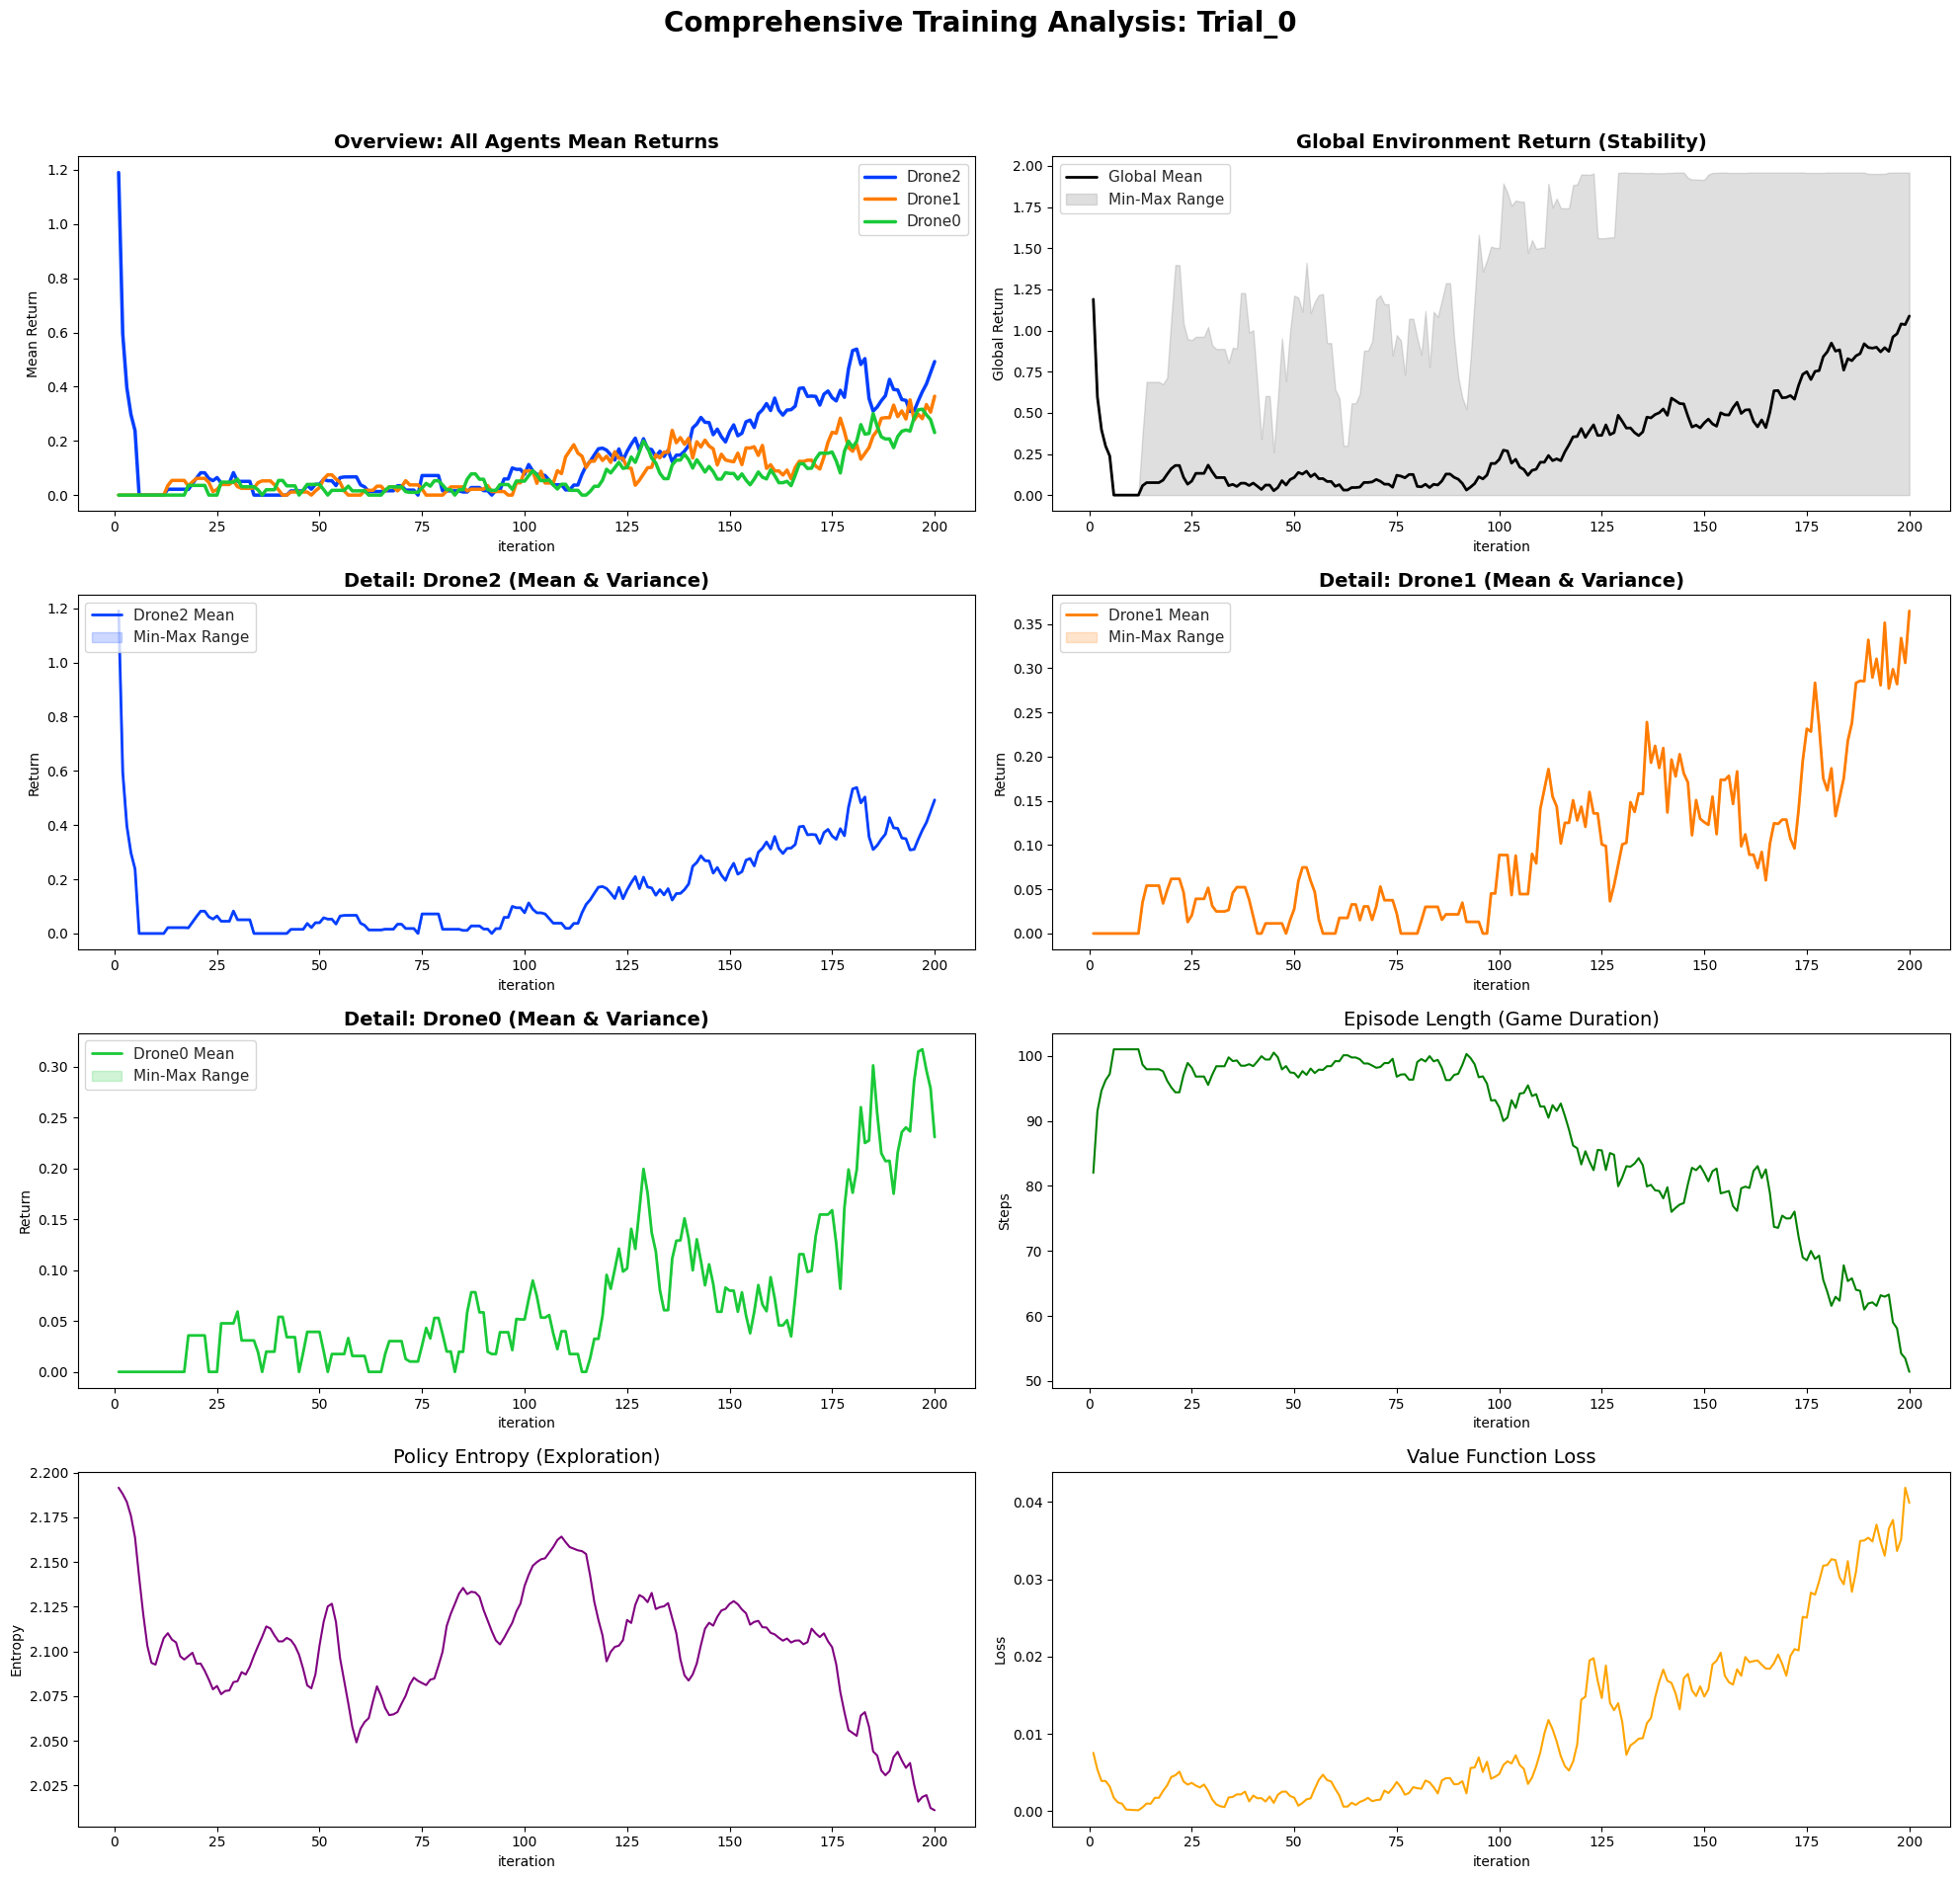

In [2]:
import os
import json
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
SMOOTHING_WINDOW = 5   # Window size for rolling average
FIG_WIDTH = 20         # Width of the entire dashboard
ROW_HEIGHT = 5         # Height per row

class TrainingDashboard:
    def __init__(self, root_dir, agent_names=None):
        """
        Args:
            root_dir (str): Path to the ray_results folder.
            agent_names (dict, optional): Mapping internal IDs to display names.
        """
        self.root_dir = root_dir
        self.agent_names = agent_names or {}
        self.data = self._load_data()
        
    def _load_data(self):
        all_records = []
        print(f"📂 Scanning directory: {self.root_dir} ...")
        
        subdirs = [f.path for f in os.scandir(self.root_dir) if f.is_dir()]
        
        for trial_idx, folder_path in enumerate(subdirs):
            json_file = os.path.join(folder_path, "result.json")
            if not os.path.exists(json_file):
                continue
            
            trial_id = f"Trial_{trial_idx}"
            
            with open(json_file, 'r') as f:
                for line in f:
                    try:
                        record = json.loads(line)
                        flat_record = self._extract_metrics(record, trial_id)
                        if flat_record:
                            all_records.append(flat_record)
                    except json.JSONDecodeError:
                        continue
                        
        if not all_records:
            print("❌ No valid data found.")
            return pd.DataFrame()
            
        df = pd.DataFrame(all_records)
        df.sort_values(by="iteration", inplace=True)
        return df

    def _extract_metrics(self, record, trial_id):
        """
        Extracts Mean, Min, Max for Global and per Agent.
        """
        try:
            # 1. Base Info
            data = {
                "trial_id": trial_id,
                "iteration": record.get("training_iteration")
            }
            
            # 2. Env Runners (Metrics source)
            # RLlib 2.x+ usually puts these in 'env_runners'
            env_runners = record.get("env_runners", {})
            if not env_runners:
                env_runners = record # Fallback for older versions

            # --- GLOBAL METRICS (Mean + Min/Max) ---
            data["return_global_mean"] = env_runners.get("episode_return_mean", record.get("episode_return_mean"))
            data["return_global_min"] = env_runners.get("episode_return_min", record.get("episode_return_min"))
            data["return_global_max"] = env_runners.get("episode_return_max", record.get("episode_return_max"))
            data["episode_len_mean"] = env_runners.get("episode_len_mean", record.get("episode_len_mean"))

            # --- PER-AGENT METRICS (Mean + Min/Max) ---
            # Extract Mean dictionaries
            agent_means = env_runners.get("agent_episode_returns_mean", {})
            # Extract Min/Max dictionaries (might not exist in all configs)
            agent_mins = env_runners.get("agent_episode_returns_min", {})
            agent_maxs = env_runners.get("agent_episode_returns_max", {})

            for agent_id, mean_val in agent_means.items():
                data[f"agent_{agent_id}_mean"] = mean_val
                # Use Mean as fallback if Min/Max are missing to prevent crash
                data[f"agent_{agent_id}_min"] = agent_mins.get(agent_id, mean_val)
                data[f"agent_{agent_id}_max"] = agent_maxs.get(agent_id, mean_val)
            
            # 3. Learner Stats (Entropy & Loss)
            learners = record.get("learners", {})
            policy_stats = {}
            # Find the first valid policy stats
            for key, val in learners.items():
                if isinstance(val, dict) and "entropy" in val:
                    policy_stats = val
                    break
            
            data["policy_entropy"] = policy_stats.get("entropy")
            data["vf_loss"] = policy_stats.get("vf_loss")
            
            return data
        except Exception:
            return None

    def plot_dashboard(self):
        if self.data.empty:
            print("⚠️ Dataframe is empty. Cannot plot.")
            return

        # 1. Identify Agents
        # Find columns like 'agent_player_0_mean'
        agent_ids = [c.replace("agent_", "").replace("_mean", "") 
                     for c in self.data.columns if c.startswith("agent_") and c.endswith("_mean")]
        
        # 2. Select Best Trial
        # Prioritize the first agent found, otherwise global mean
        sort_metric = f"agent_{agent_ids[0]}_mean" if agent_ids else "return_global_mean"
        best_trial = self.data.loc[self.data[sort_metric].idxmax()]["trial_id"]
        
        print(f"🏆 Plotting results for best trial: {best_trial}")
        df_plot = self.data[self.data["trial_id"] == best_trial].copy()
        
        # 3. Smoothing
        # Smooth every numeric column except iteration
        for col in df_plot.select_dtypes(include='number').columns:
            if col != "iteration":
                df_plot[f"{col}_smooth"] = df_plot[col].rolling(window=SMOOTHING_WINDOW, min_periods=1).mean()

        # 4. Grid Layout Calculation
        # Fixed plots: 
        #   1. Multi-Agent Comparison (Lines)
        #   2. Global Return (Band)
        #   3. Episode Length
        #   4. Entropy
        #   5. VF Loss
        # Dynamic plots:
        #   6 to N. One plot per agent (Band)
        
        num_fixed = 5
        num_dynamic = len(agent_ids)
        total_plots = num_fixed + num_dynamic
        
        ncols = 2
        nrows = math.ceil(total_plots / ncols)
        
        fig, axes = plt.subplots(nrows, ncols, figsize=(FIG_WIDTH, nrows * ROW_HEIGHT))
        fig.suptitle(f"Comprehensive Training Analysis: {best_trial}", fontsize=20, weight='bold')
        sns.set_theme(style="whitegrid")
        
        ax_flat = axes.flatten()
        plot_idx = 0
        
        # --- PLOT 1: Multi-Agent Comparison (Overview) ---
        ax = ax_flat[plot_idx]
        palette = sns.color_palette("bright", n_colors=len(agent_ids))
        
        for i, agent_id in enumerate(agent_ids):
            display_name = self.agent_names.get(agent_id, agent_id).capitalize()
            sns.lineplot(data=df_plot, x="iteration", y=f"agent_{agent_id}_mean_smooth", 
                         ax=ax, label=display_name, color=palette[i], linewidth=2.5)
        
        ax.set_title("Overview: All Agents Mean Returns", fontsize=14, weight='bold')
        ax.set_ylabel("Mean Return")
        ax.legend()
        plot_idx += 1

        # --- PLOT 2: Global Return (Mean + Min/Max) ---
        if "return_global_mean_smooth" in df_plot.columns:
            ax = ax_flat[plot_idx]
            sns.lineplot(data=df_plot, x="iteration", y="return_global_mean_smooth", 
                         ax=ax, color="black", label="Global Mean", linewidth=2)
            
            if "return_global_min_smooth" in df_plot.columns:
                ax.fill_between(
                    df_plot["iteration"],
                    df_plot["return_global_min_smooth"],
                    df_plot["return_global_max_smooth"],
                    color="gray", alpha=0.25, label="Min-Max Range"
                )
            ax.set_title("Global Environment Return (Stability)", fontsize=14, weight='bold')
            ax.set_ylabel("Global Return")
            ax.legend(loc="upper left")
            plot_idx += 1
            
        # --- PLOT 3...N: Specific Agent Details (Mean + Min/Max) ---
        for i, agent_id in enumerate(agent_ids):
            ax = ax_flat[plot_idx]
            display_name = self.agent_names.get(agent_id, agent_id).capitalize()
            color = palette[i]
            
            # Mean
            sns.lineplot(data=df_plot, x="iteration", y=f"agent_{agent_id}_mean_smooth", 
                         ax=ax, color=color, label=f"{display_name} Mean", linewidth=2)
            
            # Variance Band (Min/Max)
            col_min = f"agent_{agent_id}_min_smooth"
            col_max = f"agent_{agent_id}_max_smooth"
            
            # Check if min/max columns exist (fallback handled in extraction, but good to check)
            if col_min in df_plot.columns:
                ax.fill_between(
                    df_plot["iteration"],
                    df_plot[col_min],
                    df_plot[col_max],
                    color=color, alpha=0.2, label="Min-Max Range"
                )
                
            ax.set_title(f"Detail: {display_name} (Mean & Variance)", fontsize=14, weight='bold')
            ax.set_ylabel("Return")
            ax.legend(loc="upper left")
            plot_idx += 1

        # --- REMAINING PLOTS: Metrics ---
        
        # Episode Length
        if "episode_len_mean_smooth" in df_plot.columns and plot_idx < len(ax_flat):
            ax = ax_flat[plot_idx]
            sns.lineplot(data=df_plot, x="iteration", y="episode_len_mean_smooth", ax=ax, color="green")
            ax.set_title("Episode Length (Game Duration)", fontsize=14)
            ax.set_ylabel("Steps")
            plot_idx += 1
            
        # Entropy
        if "policy_entropy_smooth" in df_plot.columns and plot_idx < len(ax_flat):
            ax = ax_flat[plot_idx]
            sns.lineplot(data=df_plot, x="iteration", y="policy_entropy_smooth", ax=ax, color="purple")
            ax.set_title("Policy Entropy (Exploration)", fontsize=14)
            ax.set_ylabel("Entropy")
            plot_idx += 1

        # VF Loss
        if "vf_loss_smooth" in df_plot.columns and plot_idx < len(ax_flat):
            ax = ax_flat[plot_idx]
            sns.lineplot(data=df_plot, x="iteration", y="vf_loss_smooth", ax=ax, color="orange")
            ax.set_title("Value Function Loss", fontsize=14)
            ax.set_ylabel("Loss")
            plot_idx += 1

        # Clear empty subplots
        for j in range(plot_idx, len(ax_flat)):
            ax_flat[j].axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# --- EXECUTION ---

# Example mapping (Optional)
MY_AGENT_MAPPING = {
    "player_0": "CNN",
    "player_1": "CNN"
}

if 'GRID_SEARCH_DIR' in locals():
    dashboard = TrainingDashboard(GRID_SEARCH_DIR, agent_names=MY_AGENT_MAPPING)
    dashboard.plot_dashboard()
else:
    print("⚠️ Please define 'GRID_SEARCH_DIR' first.")

📂 Scanning directory: /home/nricciardi/Repositories/marl-project/checkpoints/dsse_search/PPO_2025-12-15_20-34-22 ...
🏆 Best Performing Trial selected for plotting: Trial_0


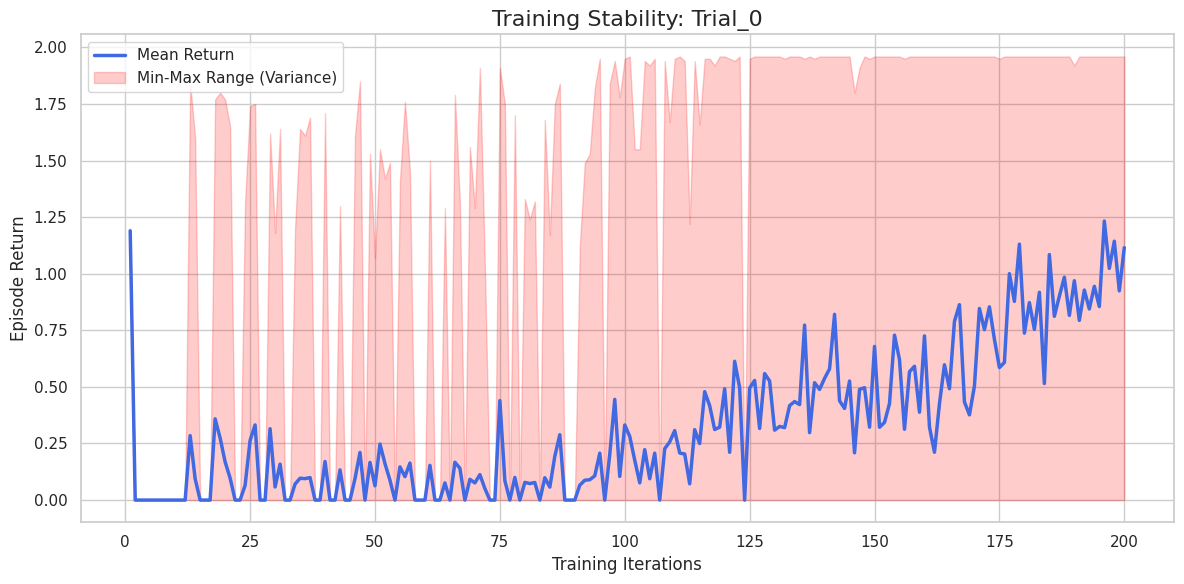

In [3]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def load_detailed_results(root_dir):
    """
    Scans for result.json and extracts Mean, Min, and Max returns.
    """
    all_data = []
    
    print(f"📂 Scanning directory: {root_dir} ...")
    subdirs = [f.path for f in os.scandir(root_dir) if f.is_dir()]
    
    for i, folder_path in enumerate(subdirs):
        json_file = os.path.join(folder_path, "result.json")
        
        if os.path.exists(json_file):
            trial_id = f"Trial_{i}"
            try:
                with open(json_file, 'r') as f:
                    for line in f:
                        try:
                            record = json.loads(line)
                            
                            # 1. Extract Metrics (prioritizing env_runners structure)
                            # RLlib often nests these inside 'env_runners'
                            runners = record.get("env_runners", {})
                            
                            # Fetch Mean, Max, Min
                            r_mean = runners.get("episode_return_mean")
                            r_max = runners.get("episode_return_max")
                            r_min = runners.get("episode_return_min")

                            # Fallback for older RLlib versions or simple structures
                            if r_mean is None: 
                                r_mean = record.get("episode_reward_mean")
                            if r_max is None: 
                                r_max = record.get("episode_reward_max")
                            if r_min is None: 
                                r_min = record.get("episode_reward_min")

                            # Only append if we have valid data
                            if r_mean is not None:
                                all_data.append({
                                    "trial_id": trial_id,
                                    "iteration": record.get("training_iteration"),
                                    "return_mean": r_mean,
                                    "return_max": r_max,
                                    "return_min": r_min,
                                    "path": folder_path
                                })
                                
                        except json.JSONDecodeError:
                            continue
            except Exception as e:
                print(f"⚠️ Error reading {folder_path}: {e}")

    if not all_data:
        return None
    return pd.DataFrame(all_data)

# --- EXECUTION ---

df = load_detailed_results(GRID_SEARCH_DIR)

if df is not None:
    # 1. Identify the Best Trial (to plot the most relevant one)
    # We select the trial that achieved the highest single mean return
    best_trial_id = df.loc[df['return_mean'].idxmax()]['trial_id']
    print(f"🏆 Best Performing Trial selected for plotting: {best_trial_id}")
    
    # Filter data for only the best trial
    best_df = df[df['trial_id'] == best_trial_id].sort_values("iteration")
    
    # 2. Setup Plot
    plt.figure(figsize=(12, 6))
    sns.set_theme(style="whitegrid")
    
    # A. Plot the Mean Line
    sns.lineplot(
        data=best_df,
        x="iteration",
        y="return_mean",
        color="royalblue",
        linewidth=2.5,
        label="Mean Return"
    )
    
    # B. Plot the Min/Max Band (Variance)
    # We use fill_between from matplotlib
    plt.fill_between(
        best_df["iteration"],
        best_df["return_min"],
        best_df["return_max"],
        color="red",
        alpha=0.2, # Transparency (0.0 to 1.0)
        label="Min-Max Range (Variance)"
    )
    
    # 3. Formatting
    plt.title(f"Training Stability: {best_trial_id}", fontsize=16)
    plt.xlabel("Training Iterations", fontsize=12)
    plt.ylabel("Episode Return", fontsize=12)
    plt.legend(loc="upper left")
    
    plt.tight_layout()
    plt.show()

else:
    print("❌ No data found.")